In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install gensim
!pip install warnings
!pip install pyLDAvis

In [0]:
import pandas as pd
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
import nltk
nltk.download('wordnet')

##Loading the raw data

In [4]:
df_garden = pd.read_csv('/content/drive/My Drive/Amazon_data/reviews_Patio_Lawn_And_Garden.csv', error_bad_lines= False , nrows= 100000)
df_garden.shape

(100000, 9)

In [5]:
df_garden.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2VNYWOPJ13AFP,0981850006,"Amazon Customer ""carringt0n""","[6, 7]",This was a gift for my other husband. He's ma...,5.0,Delish,1259798400,"12 3, 2009"
1,A20DWVV8HML3AW,0981850006,Cyndy,"[0, 0]","My husband rarely asks for anything specific, ...",5.0,Just what my husband wanted,1371081600,"06 13, 2013"
2,A3RVP3YBYYOPRH,0981850006,John Warren,"[9, 11]",This guy knows his stuff. I love the seriously...,5.0,Love This Show!,1257984000,"11 12, 2009"
3,A28XY55TP3Q90O,0981850006,"JSG ""Lover of Learning""","[1, 1]","THIS CAN BE FOUND AT: [...] FOR $19.99, also a...",5.0,"BUY ELSEWHERE, TOO EXPENSIVE",1314144000,"08 24, 2011"
4,A3VZW1BGUQO0V3,0981850006,"Marc G. Belisle ""Allswell2001""","[2, 2]",Quite good particularly for inspiration (DVD g...,5.0,Quite good but I *much* prefer the cookbooks,1308268800,"06 17, 2011"


##Pre-processing the reviewText 

In [6]:
# Convert to array
docs =array(df_garden['reviewText'].astype(str))
print(type(docs))
print(len(docs))
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

<class 'numpy.ndarray'>
100000
Number of unique tokens: 17697
Number of documents: 100000
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)]]


In [0]:
type(corpus)

list

##LDA on the ReviewText Column of the Amazon Data

In [7]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.054*"product" + 0.016*"would_recommend" + 0.014*"feeder" + 0.013*"recommend" + 0.012*"item" + 0.012*"amazon" + 0.012*"well_made" + 0.010*"better_than" + 0.010*"from" + 0.009*"been_using"'), (1, '0.018*"trap" + 0.014*"them" + 0.014*"mouse" + 0.012*"plant" + 0.009*"grill" + 0.009*"these" + 0.007*"house" + 0.007*"keep" + 0.007*"love" + 0.007*"table"'), (2, '0.015*"time" + 0.015*"year" + 0.013*"after" + 0.012*"more" + 0.012*"will" + 0.011*"about" + 0.010*"only" + 0.010*"bought" + 0.009*"water" + 0.009*"from"'), (3, '0.018*"yard" + 0.013*"grass" + 0.012*"battery" + 0.011*"look_like" + 0.010*"light_weight" + 0.009*"fence" + 0.009*"leaf" + 0.008*"power" + 0.008*"burner" + 0.007*"about_minute"'), (4, '0.016*"good" + 0.016*"easy" + 0.011*"like" + 0.008*"handle" + 0.008*"need" + 0.008*"little" + 0.008*"make" + 0.008*"your" + 0.007*"tool" + 0.007*"what"')]


##Evaluating the LDA Model

In [8]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3268774180076323


In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

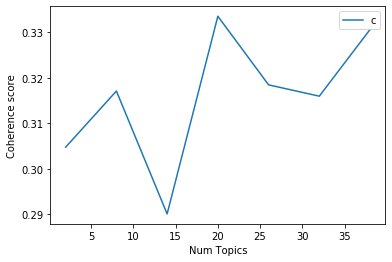

<Figure size 432x288 with 0 Axes>

In [10]:
#Model list and plot Coherence score against a number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig('Coherence score against a number of topics- Review_Text', dpi = 500)

##Pre-processing the Summary column of the AMazon Dataset

In [25]:
# Convert to array
docs =array(df_garden['summary'].astype(str))
print(type(docs))
print(len(docs))
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

<class 'numpy.ndarray'>
100000
Number of unique tokens: 3085
Number of documents: 100000
[[]]


##LDA on the Summary column of the Amazon Dataset

In [26]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.122*"this" + 0.057*"perfect" + 0.042*"doe" + 0.037*"tool" + 0.036*"have" + 0.036*"grill" + 0.033*"your" + 0.031*"stuff" + 0.031*"plant" + 0.029*"really"'), (1, '0.278*"great" + 0.117*"product" + 0.053*"love" + 0.036*"quality" + 0.032*"easy" + 0.029*"price" + 0.028*"better_than" + 0.026*"better" + 0.024*"money" + 0.024*"little"'), (2, '0.093*"five_star" + 0.050*"star" + 0.047*"made" + 0.045*"well_made" + 0.040*"small" + 0.036*"these" + 0.036*"more" + 0.034*"five" + 0.032*"that" + 0.028*"doesn"'), (3, '0.222*"work" + 0.079*"very" + 0.055*"nice" + 0.054*"well" + 0.049*"with" + 0.038*"like" + 0.029*"awesome" + 0.027*"worked" + 0.021*"cover" + 0.020*"need"'), (4, '0.169*"good" + 0.070*"best" + 0.048*"excellent" + 0.047*"what" + 0.038*"just" + 0.035*"just_what" + 0.028*"ever" + 0.022*"time" + 0.018*"effective" + 0.017*"used"')]


##Evaluating the LDA Model

In [27]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.38654120411864723


In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

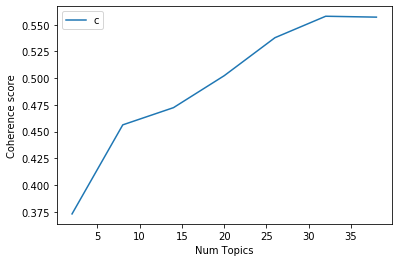

<Figure size 432x288 with 0 Axes>

In [29]:
#Model list and plot Coherence score against a number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig('Coherence score against a number of topics - Summary', dpi = 500)

##Now Working on the Meta-Data of Amazon. This is to check if the LDA works better on the category data

In [0]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [0]:
df_meta = getDF('/content/drive/My Drive/Amazon_data/meta_Patio_Lawn_and_Garden.json.gz')

In [19]:
df_meta.shape #should be (279697, 18)
df_meta.head()
df_meta.columns
#type(df_meta.category)

Index(['category', 'tech1', 'description', 'title', 'also_buy', 'brand',
       'feature', 'rank', 'main_cat', 'date', 'price', 'asin', 'image',
       'also_view', 'similar_item', 'details', 'fit', 'tech2'],
      dtype='object')

In [15]:
df_meta.to_csv('Amazon_Meta_Data_LawnAndGarden.csv')
!cp Amazon_Meta_Data_LawnAndGarden.csv /content/drive/My Drive/Amazon_data

cp: target 'Drive/Amazon_data' is not a directory


##Pre-processing of the meta data

In [20]:
# Convert to array
docs =array(df_meta['category'].astype(str))
print(type(docs))
print(len(docs))
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

<class 'numpy.ndarray'>
279697
Number of unique tokens: 878
Number of documents: 279697
[[(0, 1), (1, 2), (2, 1), (3, 1)]]


##LDA Implementation

In [21]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.286*"part" + 0.169*"replacement" + 0.110*"mower" + 0.077*"power" + 0.038*"ranch" + 0.038*"farm" + 0.031*"agricultural" + 0.030*"construction" + 0.030*"machinery" + 0.027*"umbrella"'), (1, '0.194*"flag" + 0.118*"doormat" + 0.065*"set" + 0.046*"indoor" + 0.044*"hand" + 0.043*"hydroponics" + 0.032*"pond" + 0.028*"sign" + 0.028*"yard" + 0.027*"water"'), (2, '0.124*"plant" + 0.107*"bulb" + 0.106*"seed" + 0.084*"furniture" + 0.047*"planter" + 0.045*"statue" + 0.042*"container" + 0.042*"pot" + 0.037*"flower" + 0.034*"sculpture"'), (3, '0.101*"equipment" + 0.098*"watering" + 0.076*"power" + 0.063*"hammock" + 0.049*"hose" + 0.043*"generator" + 0.041*"stand" + 0.041*"furniture" + 0.038*"portable" + 0.035*"tree"'), (4, '0.166*"cooking" + 0.145*"grill" + 0.061*"pool" + 0.053*"supply" + 0.050*"control" + 0.050*"pest" + 0.044*"tub" + 0.031*"cover" + 0.030*"barbecue" + 0.029*"repellent"')]


##LDA Evaluation

In [22]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5146668543203112


In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

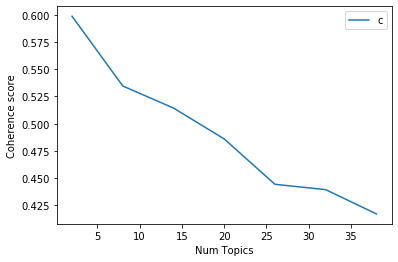

<Figure size 432x288 with 0 Axes>

In [24]:
#Model list and plot Coherence score against a number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig('Coherence score against a number of topics - MetaData', dpi = 500)

##Comparing the Coherence Scores per LDA Implementation